# Install the libraries

In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, reduce
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 
from experiment import AdaptiveEBM

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def make_adaptive_experiment(config):
    ebm = make_energy_model(config, path=path)
    emb = ebm.to("cuda")
    adapt = AdaptiveEBM(config, ebm)
    return adapt

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def pixelwise_varaince(imgs):
    ex = reduce(imgs, "b h w -> h w", "mean")
    ex2 = reduce(imgs**2, "b h w -> h w", "mean")
    return ex2 - ex**2

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

# Inpainting

In [2]:
model_name = "mnist/gan/langevin/inpainting"
config = get_model_config(model_name)
dm = mnist_dataloader_test(config, path=path)

/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Config

In [3]:
config["exp_params"]["batch_size"] = 1
dm = mnist_dataloader_test(config, path=path)

In [4]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

# Adaptive Experiments

In [7]:
config["operator_params"]["size"] = 28
config["estimator_params"]["burn_in"] = 150

In [8]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def adaptive_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    avg_error = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        error = []
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
            error.append(reconstruction_error(x, x_hat).detach().cpu())
        avg_error.append(sum(error)/len(error))
        A = adapt.adaptive_sample(imgs)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        plt.show()
    return avg_error

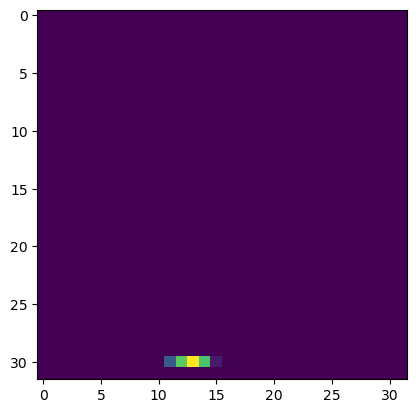

100%|██████████| 10/10 [00:03<00:00,  2.50it/s]
/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


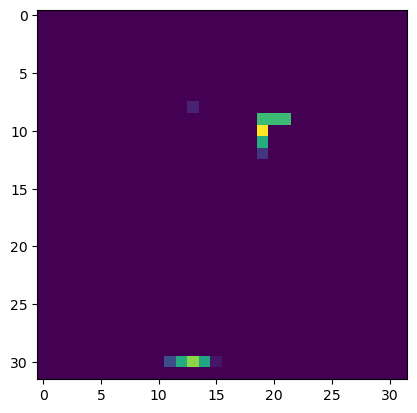

100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


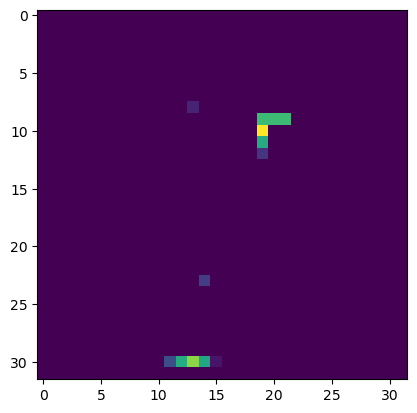

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


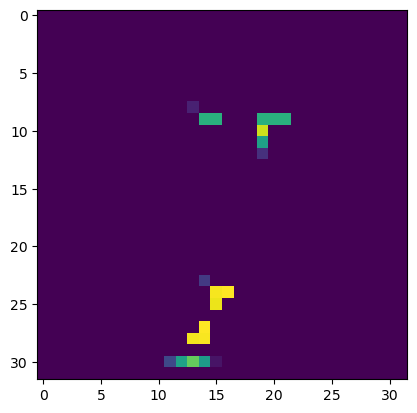

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


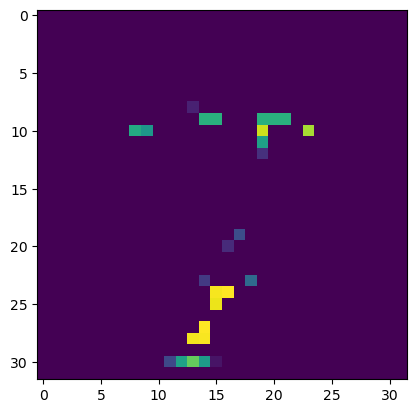

 30%|███       | 3/10 [00:00<00:02,  3.02it/s]

In [9]:
avg_error = adaptive_iteration(x)

In [16]:
def non_adaptive_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    avg_error = []
    for i in range(20):
        imgs = torch.zeros(100, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        error = []
        for num in trange(0, 100):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
            error.append(reconstruction_error(x, x_hat).detach().cpu())
        avg_error.append(sum(error)/len(error))
        A = adapt.non_adaptive_sample(imgs)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        plt.show()
    return avg_error

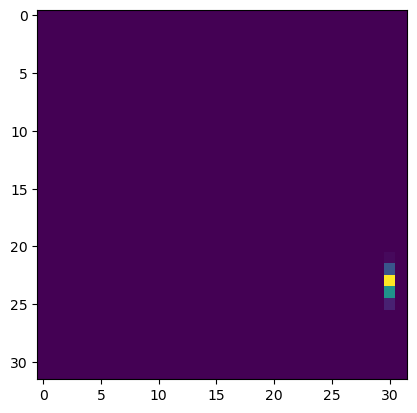

100%|██████████| 100/100 [00:03<00:00, 29.35it/s]


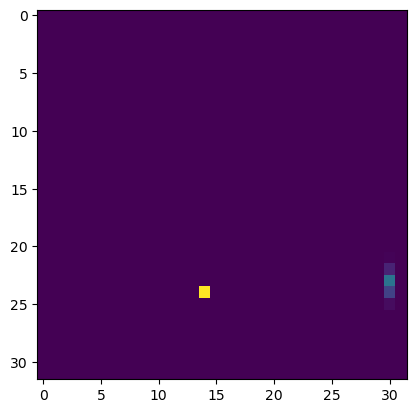

100%|██████████| 100/100 [00:03<00:00, 28.80it/s]


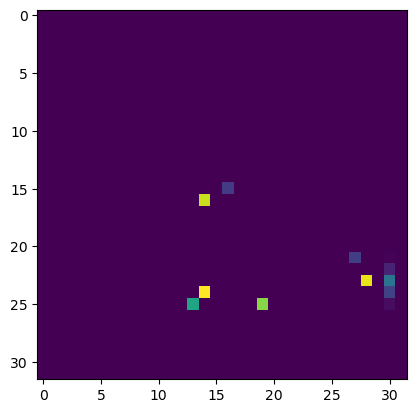

100%|██████████| 100/100 [00:03<00:00, 28.84it/s]


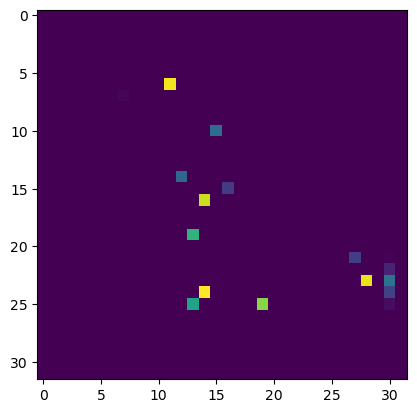

100%|██████████| 100/100 [00:03<00:00, 29.26it/s]


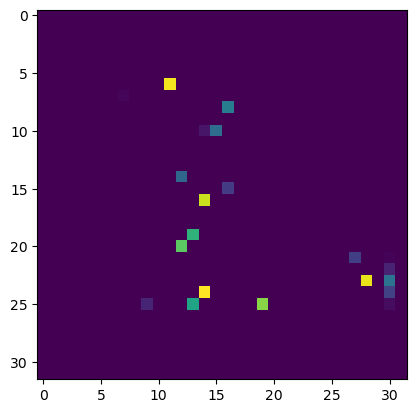

100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


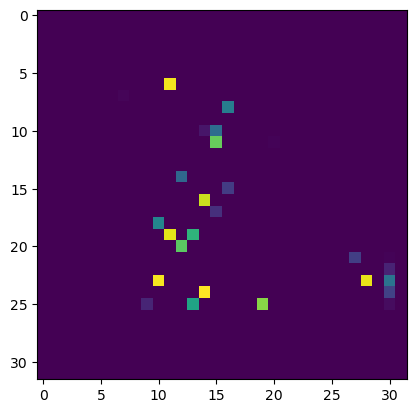

100%|██████████| 100/100 [00:03<00:00, 31.35it/s]


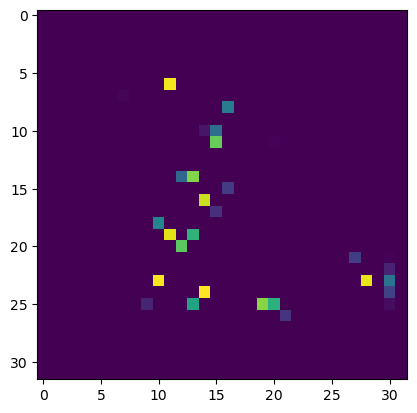

100%|██████████| 100/100 [00:03<00:00, 29.73it/s]


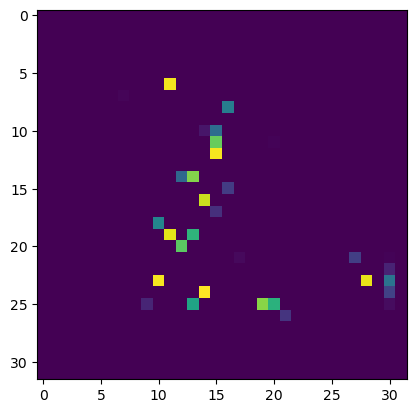

100%|██████████| 100/100 [00:03<00:00, 28.85it/s]


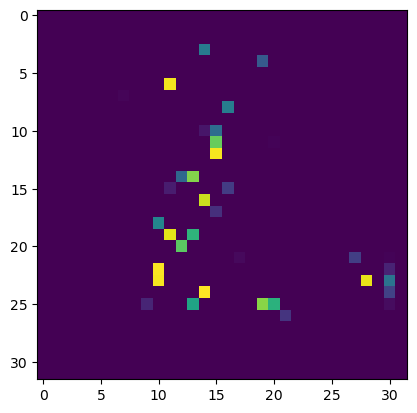

100%|██████████| 100/100 [00:03<00:00, 29.26it/s]


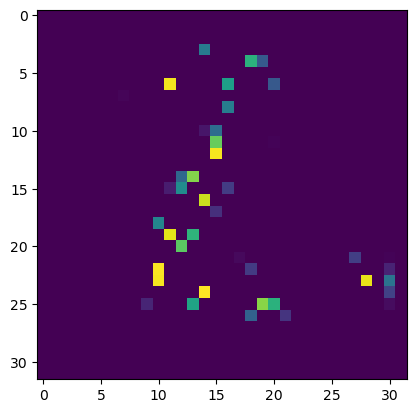

100%|██████████| 100/100 [00:03<00:00, 29.01it/s]


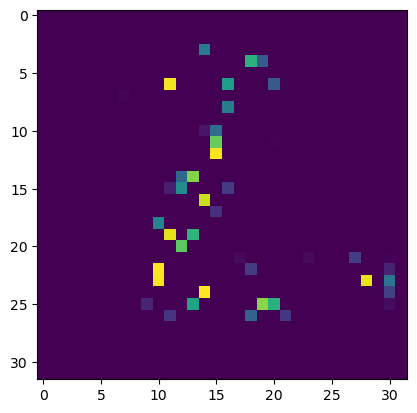

100%|██████████| 100/100 [00:03<00:00, 30.28it/s]


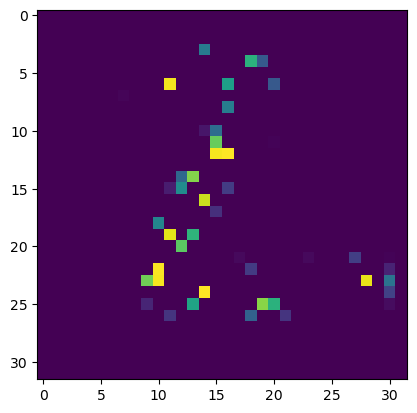

100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


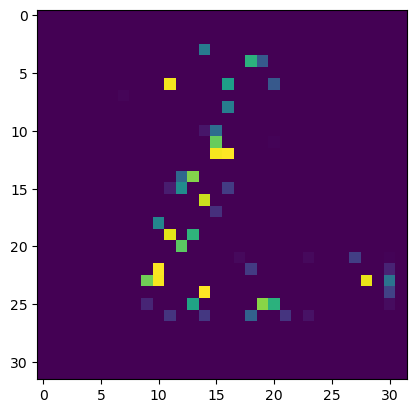

100%|██████████| 100/100 [00:03<00:00, 30.49it/s]


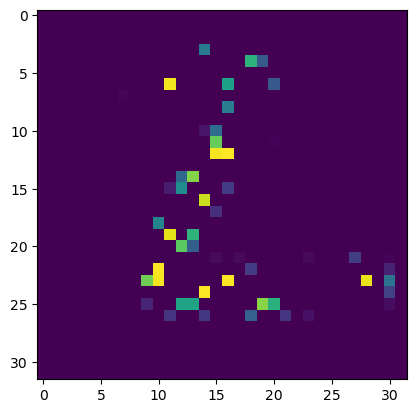

100%|██████████| 100/100 [00:03<00:00, 28.94it/s]


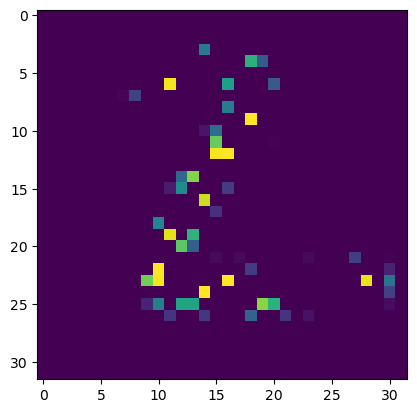

100%|██████████| 100/100 [00:03<00:00, 31.51it/s]


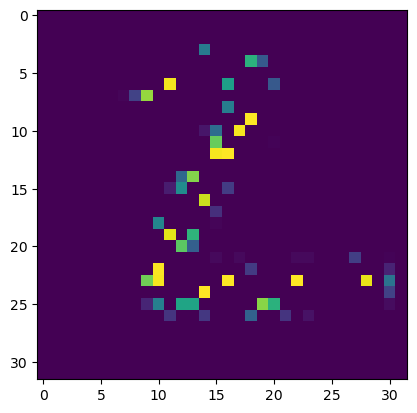

100%|██████████| 100/100 [00:03<00:00, 30.03it/s]


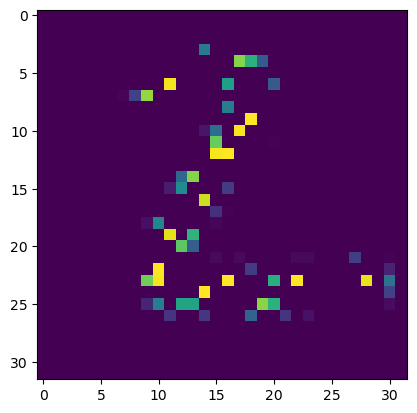

100%|██████████| 100/100 [00:03<00:00, 28.98it/s]


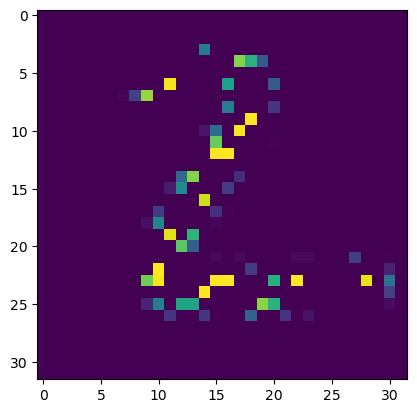

100%|██████████| 100/100 [00:03<00:00, 29.11it/s]


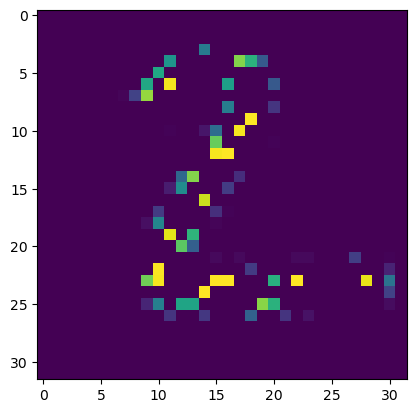

100%|██████████| 100/100 [00:03<00:00, 29.01it/s]


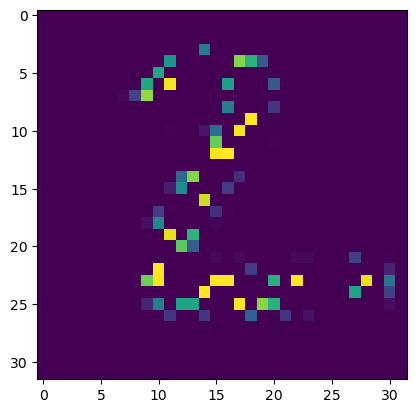

100%|██████████| 100/100 [00:03<00:00, 29.08it/s]


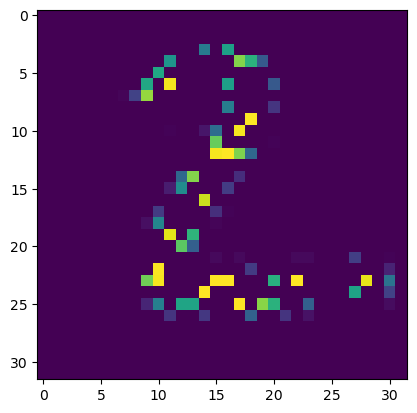

In [17]:
avg_error_non_adptive = non_adaptive_iteration(x)

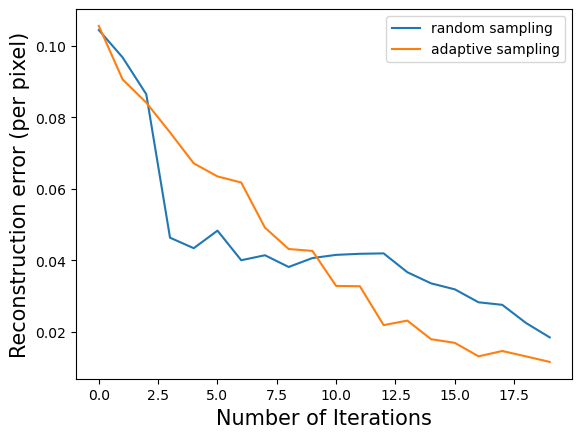

In [18]:
plt.xlabel('Number of Iterations', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.plot(avg_error_non_adptive)
plt.plot(avg_error)
plt.legend(['random sampling','adaptive sampling'])
plt.show()

In [7]:
def adaptive_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    avg_error = []
    n_samples = 10
    num_iter = 20
    for i in range(num_iter):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        error = []
        for num in range(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
            error.append(reconstruction_error(x, x_hat).detach().cpu())
        avg_error.append(sum(error)/len(error))
        A = adapt.adaptive_sample(imgs)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
    return np.array(avg_error, dtype=np.float32)

In [8]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

In [9]:
avg_adaptive_error = np.zeros(20, dtype=np.float32)
avg_adaptive_error_2 = np.zeros(20, dtype=np.float32)
for t in trange(1, 100):
    x, y = next(gen)
    x = x.to("cuda")
    error = adaptive_iteration(x)
    avg_adaptive_error = ((t-1)/t)*avg_adaptive_error + (1/t)*error
    avg_adaptive_error_2 = ((t-1)/t)*avg_adaptive_error_2 + (1/t)*(error**2)

  0%|          | 0/99 [00:00<?, ?it/s]/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 32, 32])) that is different to the input size (torch.Size([1, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100%|██████████| 99/99 [1

In [10]:
def non_adaptive_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    error = []
    num_iter = 20
    for _ in range(num_iter):
        x_tilde = adapt.ebm.operator(x)
        x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
        error.append(reconstruction_error(x, x_hat).detach().cpu())
        A = adapt.non_adaptive_sample(torch.zeros(1, 32, 32))
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
    return np.array(error, dtype=np.float32)

In [11]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

In [12]:
avg_error_non_adaptive = np.zeros(20, dtype=np.float32)
avg_error_non_adaptive_2 = np.zeros(20, dtype=np.float32)
for t in trange(1, 100):
    x, y = next(gen)
    x = x.to("cuda")
    error = non_adaptive_iteration(x)
    avg_error_non_adaptive = ((t-1)/t)*avg_error_non_adaptive + (1/t)*error
    avg_error_non_adaptive_2 = ((t-1)/t)*avg_error_non_adaptive_2 + (1/t)*error**2

100%|██████████| 99/99 [01:09<00:00,  1.42it/s]


In [13]:
std_adaptive = np.sqrt(avg_adaptive_error_2-avg_adaptive_error**2)
std_non_adptive = np.sqrt(avg_error_non_adaptive_2 -avg_error_non_adaptive**2)

In [21]:
print(len(avg_error_non_adaptive))
print(len(std_non_adptive))

20
20


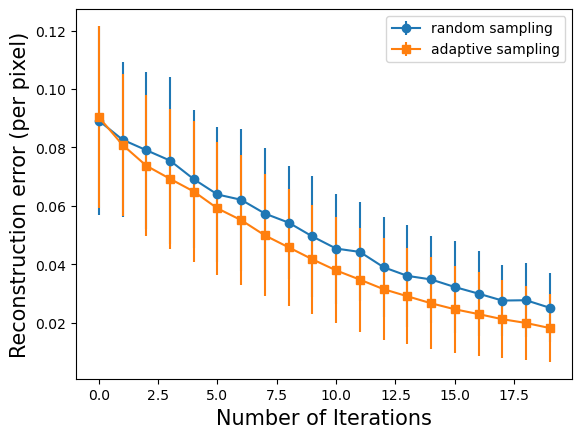

In [22]:
plt.xlabel('Number of Iterations', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.errorbar(list(range(1, 21)), avg_error_non_adaptive, yerr=std_non_adptive, fmt='-o')
plt.errorbar(list(range(1, 21)), avg_adaptive_error, yerr=std_adaptive, fmt='-s')
plt.legend(['random sampling','adaptive sampling'])
plt.show()

In [23]:
import random 

def epsilon_greedy_adaptive_iteration(x, epsilon=0.5):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    error = []
    num_iter = 20
    n_samples = 10
    for _ in range(num_iter):
        if random.random()>epsilon:
            imgs = torch.zeros(n_samples, 32, 32)
            x_tilde = adapt.ebm.operator(x)
            _error = []
            for num in range(0, n_samples):
                x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
                imgs[num, : , :] = x_hat
                _error.append(reconstruction_error(x, x_hat).detach().cpu())
            error.append(sum(_error)/len(_error))
            A = adapt.adaptive_sample(imgs)
            adapt.update_operator(A)
            x_tilde = adapt.ebm.operator(x)
        else:
            x_tilde = adapt.ebm.operator(x)
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            error.append(reconstruction_error(x, x_hat).detach().cpu())
            A = adapt.non_adaptive_sample(torch.zeros(1, 32, 32))
            adapt.update_operator(A)
            x_tilde = adapt.ebm.operator(x)
        
    return np.array(error, dtype=np.float32)

In [24]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

In [25]:
avg_error_e_greedy_adaptive = np.zeros(20, dtype=np.float32)
avg_error_e_greedy_adaptive2 = np.zeros(20, dtype=np.float32)
for t in trange(1, 100):
    x, y = next(gen)
    x = x.to("cuda")
    error = epsilon_greedy_adaptive_iteration(x)
    avg_error_e_greedy_adaptive = ((t-1)/t)*avg_error_e_greedy_adaptive + (1/t)*error
    avg_error_e_greedy_adaptive2 = ((t-1)/t)*avg_error_e_greedy_adaptive2 + (1/t)*error**2

100%|██████████| 99/99 [06:00<00:00,  3.64s/it]


In [26]:
std_adaptive = np.sqrt(avg_adaptive_error_2-avg_adaptive_error**2)
std_non_adptive = np.sqrt(avg_error_non_adaptive_2 -avg_error_non_adaptive**2)
std_e_greedy = np.sqrt(avg_error_e_greedy_adaptive2 -avg_error_e_greedy_adaptive**2)

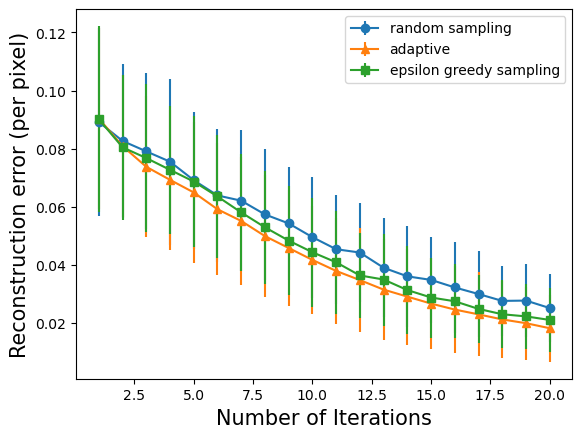

In [28]:
plt.xlabel('Number of Iterations', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.errorbar(list(range(1, 21)), avg_error_non_adaptive, yerr=std_non_adptive, fmt='-o')
plt.errorbar(list(range(1, 21)), avg_adaptive_error, yerr=std_adaptive, fmt='-^')
plt.errorbar(list(range(1, 21)), avg_error_e_greedy_adaptive, yerr=std_e_greedy, fmt='-s')
plt.legend(['random sampling', 'adaptive', 'epsilon greedy sampling'])
plt.show()